In [1]:
from fastai.vision.all import *

Custom TransformBlock creation and show methods

In [2]:
def _fig_bounds(x):
    # not sure why this is here but fast.ai uses it in their show_image method
    r = x//32
    return min(5, max(1,r))


def scale_tensor_to_image(im_tensor):
    # scales the tensor values to fit between 0 and 1
    im_min = torch.min(im_tensor)
    im_max = torch.max(im_tensor)
    return (255*(im_tensor - im_min)//(im_max - im_min)).type(torch.uint8)


def show_tensor_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    # basically fast.ai's show_image with an additional function to scale the values
    # between 0 and 1 for arbitrary tensors
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    
    if torch.max(im) != torch.min(im):
        im = scale_tensor_to_image(im)
    else:
        im = im.type(torch.uint8)

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax


class TorchTensorImage(TensorImage):
    # defines the fast.ai TransformBlock needed for torch tensors to work within fast.ai DataBlocks
    # TensorImage base class seems to work best but the other two sort of work
    #class TorchTensorImage(Tensor):
    #class TorchTensorImage(TensorBase):
    _show_args = {'cmap':'viridis'}
    @classmethod
    def create(cls, fn: (Path, str)) -> None:
        # fn is filename, use this method to handle how your data should be loaded
        # will need to be changed to load your data in a form your model can handle
        tens = torch.load(fn)
        #return cls(tens)
        input_tensor = torch.stack((tens, tens, tens))
        #input_tensor = tens[1:4,:,:].clone()
        #tens_center = tens[2,:,:].clone()
        #input_tensor = torch.stack((tens_center, tens_center, tens_center))
        return cls(input_tensor)
        

    def show(self, ctx=None, **kwargs):
        # defines how your tensor should be displayed
        "Show image using `merge(self._show_args, kwargs)`"
        return show_tensor_image(self, ctx=ctx, **merge(self._show_args, kwargs))


class TorchTensorMask(TensorMask):
    # defines a fast.ai TransformBlock that will load torch tensors as masks within fast.ai DataBlocks
    _show_args = {'alpha':0.5, 'cmap':'tab20'}
    @classmethod
    def create(cls, fn: (Path, str)) -> None:
        # fn is filename, use this method to handle how your mask should be loaded
        tens = torch.load(fn)
        return cls(tens)
    
    def show(self, ctx=None, **kwargs):
        # defines how the mask should be displayed
        "Show image using `merge(self._show_args, kwargs)`"
        return show_tensor_image(self, ctx=ctx, **merge(self._show_args, kwargs))


def TensorImageBlock():
    # creates the torch Tensor TransformBlock using the above Transforms
    return TransformBlock(type_tfms=TorchTensorImage.create, batch_tfms=IntToFloatTensor(div=1))


def TensorMaskBlock(codes):
    # creates the torch Tensor mask TransformBlock using the other above Transforms
    return TransformBlock(type_tfms=TorchTensorMask.create, item_tfms=AddMaskCodes(codes=codes)) #, batch_tfms=IntToFloatTensor(div=1))

Methods used in creating the DataBlock

In [12]:
def _parent_idxs(items, name):
    # finds the indices for a file splitter based on the parent folder
    def _inner(items, name):
        return mask2idxs(Path(o).parent.name == name for o in items)
    return [i for n in L(name) for i in _inner(items, n)]


def ParentSplitter(train_name='train', valid_name='valid'):
    # actually splits the files based on the parent folder
    "Split `items` from the parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _parent_idxs(o, train_name), _parent_idxs(o, valid_name)
    return _inner


def get_msk(o):
    # loads the mask for my data based on how I set up my folder structure
    path_pieces = o.parts
    new_path = []
    for i in range(len(path_pieces)):
        if path_pieces[i] == 'tensors':
            new_path.append('masks')
            continue
        new_path.append(path_pieces[i])
    mask_path = os.sep.join(new_path)
    return Path(mask_path)


class custom_dice(Metric):
    # Pouria's code for the soft Dice metric
    # might do some weird stuff with it later
    "Dice coefficient metric (DSC) class for a binary target in segmentation"
    def __init__(self, axis=1, object_class=1):
        self.axis = axis
        self.object_class = object_class

    def reset(self):
        self.inter, self.union = 0, 0

    def accumulate(self, learn):
        preds, targs = learn.pred, learn.y
        # Shape of preds and targs: (torch.Size([2, 3, 512, 512]), torch.Size([2, 512, 512]))
        preds = torch.softmax(preds,dim=1).float()
        # Don't forget that activation functions are not applied on the learn.pred, so we apply it ourselves!
        pred = preds[:, self.object_class, ...]
        # Picking up the values for our desired channel from the predictions.
        targ = (targs==self.object_class).float()
        # Filtering the target values based on our desired channel.
        self.inter+=(pred*targ).sum()
        self.union+=(pred+targ).sum()
        # Measuring the inter and union values for each batch and summing them up with the previous values.
    @property
    def value(self):
        return 2.*self.inter/self.union if self.union > 0 else None


class liver_dice(custom_dice):
    # Pouria's code to use the soft Dice metric in our learners
    def __init__(self):
        super().__init__(self, object_class=1)


def torch_tensor_creator(num_tensors):
    # This function just creates some random tensors for testing
    tensor_list = []
    for i in range(num_tensors):
        tensor_name = "tensor_" + str(i)
        tensor_list.append(tensor_name)
    
    #tensor_list = ["tensor_1", "tensor_2", "tensor_3", "tensor_4", "tensor_5", "tensor_6", "tensor_7", "tensor_8"]

    base_path = r"C:\Users\Joe\Downloads\torch_tensor_test"
    train_tensor_path = base_path + r"\tensors\train"
    valid_tensor_path = base_path + r"\tensors\valid"
    train_mask_path = base_path + r"\masks\train"
    valid_mask_path = base_path + r"\masks\valid"

    for tensor_name in tensor_list:
        #train_tensor = torch.rand((128, 128), dtype=torch.float32)
        #valid_tensor = torch.rand((128, 128), dtype=torch.float32)
        #train_mask = torch.randint(high=2, size=(128, 128), dtype=torch.float32)
        #valid_mask = torch.randint(high=2, size=(128, 128), dtype=torch.float32)
        train_tensor = torch.randint(low=-1000, high=1000, size=(128, 128), dtype=torch.float32)
        valid_tensor = torch.randint(low=-1000, high=1000, size=(128, 128), dtype=torch.float32)
        #train_mask = torch.randint(high=2, size=(128, 128), dtype=torch.float32)
        #valid_mask = torch.randint(high=2, size=(128, 128), dtype=torch.float32)
        tens_1 = torch.ones(size=(128, 128))
        tens_0 = torch.zeros(size=(128, 128))
        #train_mask = torch.ones(size=(128, 128))
        #valid_mask = torch.ones(size=(128, 128))
        #train_mask = torch.where(train_tensor[2,:,:]<-50, tens_1, tens_0)
        #valid_mask = torch.where(valid_tensor[2,:,:]<-50, tens_1, tens_0)
        
        #train_tensor = torch.zeros(size=(128, 128))
        #valid_tensor = torch.zeros(size=(128, 128))
        train_tensor[:,:50] = tens_0[:,:50]
        valid_tensor[:,:50] = tens_0[:,:50]
        
        train_mask = torch.zeros(size=(128, 128))
        valid_mask = torch.zeros(size=(128, 128))
        train_mask[:50,:] = tens_1[:50,:]
        valid_mask[:50,:] = tens_1[:50,:]

        torch.save(train_tensor, os.path.join(train_tensor_path, tensor_name + '.pt'))
        torch.save(valid_tensor, os.path.join(valid_tensor_path, tensor_name + '.pt'))
        torch.save(train_mask, os.path.join(train_mask_path, tensor_name + '.pt'))
        torch.save(valid_mask, os.path.join(valid_mask_path, tensor_name + '.pt'))

    return None

In [13]:
# create some random tensors for testing
torch_tensor_creator(24)

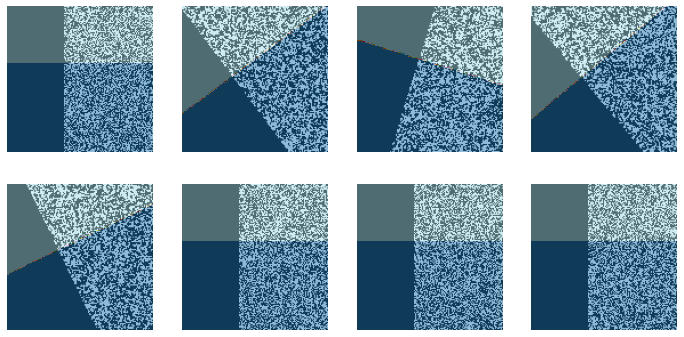

In [18]:
# testing dataset, dataloader, and show_batch methods
path = r"C:\Users\Joe\Downloads\torch_tensor_test"

datablock = DataBlock(
                blocks=(TensorImageBlock, TensorMaskBlock(codes=['ones'])),
                get_items=FileGetter(extensions='.pt', folders=['tensors']),
                #get_y=MaskGetter(masklabel='masks', tensorlabel='tensors'),
                get_y=get_msk,
                splitter=ParentSplitter(train_name='train', valid_name='valid'))

#dsets = datablock.datasets(Path(path))
#print(dsets.train)

datablock2 = datablock.new(batch_tfms=Rotate(max_deg=45))
#datablock2 = datablock.new(batch_tfms=aug_transforms(mult=2))

dataloaders = datablock2.dataloaders(Path(path), bs=8, num_workers=0)
#print(dataloaders.one_batch())

#print(torch.unique(dataloaders.one_batch()[1]))
dataloaders.train.show_batch(max_n=8, nrows=2)

In [7]:
# testing training
dice_1 = liver_dice()

modelsavepath = r"C:\Users\Joe\Downloads\torch_tensor_test"
modelsavedir = r"\model\\"

learn = unet_learner(dls=dataloaders, arch=resnet34, metrics=[foreground_acc, dice_1], n_out=2, loss_func=CrossEntropyLossFlat(axis=1), path=modelsavedir, model_dir=modelsavedir)

#learn.fine_tune(1)
learn.fit(5)

epoch     train_loss  valid_loss  foreground_acc  liver_dice  time    
0         14.221861   0.732907    0.951875        0.469780    00:03     
1         7.255619    0.657949    0.026094        0.399046    00:00     
2         4.898706    0.405881    0.697031        0.603662    00:00     
3         3.866062    0.799229    0.020469        0.263393    00:00     
4         3.148795    0.630714    0.139687        0.430854    00:00     
